In [2]:
from a1 import (plot, freq_response, MLKF_3_storey, MLKF_3_storey_1st_floor_damped, 
                MLKF_3_storey_2nd_floor_damped, MLKF_3_storey_3rd_floor_damped, 
                MLKF_3_storey_all_floors_damped)
import numpy as np
import matplotlib.pyplot as plt

### Undamped system response

Using $m=3.94$, $k=2101$ and $\lambda = 2.48$ for all three storeys

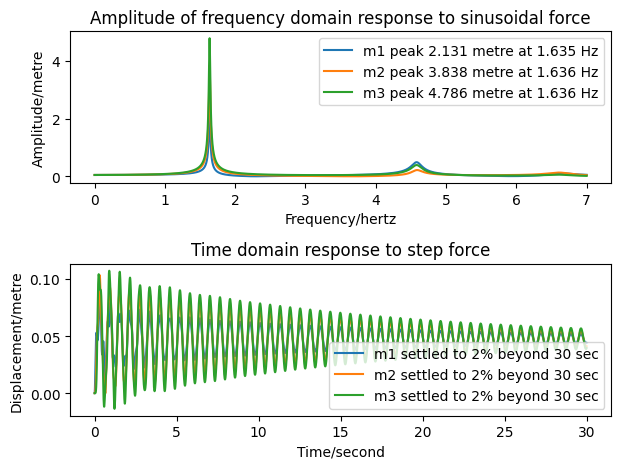

In [5]:
M, L, K, F = MLKF_3_storey(3.94, 2.48, 2101, 100, 3.94, 2.48, 2101, 0, 3.94, 2.48, 2101, 0)
# Generate frequency and time arrays

hz = np.linspace(0, 7, 10001)
sec = np.linspace(0, 30, 10001)

# Plot results

fig = plt.figure()
plot(fig, hz, sec, M, L, K, F, None)
fig.canvas.mpl_connect('resize_event', lambda x: fig.tight_layout(pad=2.5))
plt.show()

### Find the natural frequencies of the three modes of vibration. 

Scan along frequency response of a mass to find all the peaks.

In [27]:
hz = np.linspace(0, 7, 10001)
fs = hz*2*np.pi
Ys = freq_response(fs, M, L, K, F)

In [39]:
Y = np.abs(Ys[:, 0])
prev = 0.0
peaks = [] # List[tuple[f, y]]
is_rising = True
for i, y in enumerate(Y):
    if y < prev and is_rising:
        peaks.append((fs[i], np.abs(Ys[i])))
        is_rising = False
    elif y > prev and not is_rising:
        is_rising = True
    prev = y

In [40]:
peaks

[(10.278662844015084, array([2.12972966, 3.83795433, 4.78604089])),
 (28.786413484843276, array([0.48999021, 0.21742601, 0.39197011])),
 (41.743598225309015, array([0.10715377, 0.12730169, 0.05619032]))]

For each natural frequency peak, find the required spring constant of a mass damper

$ k = \omega^2 m$

In [147]:
ks = [peak[0]**2 * 0.15 for peak in peaks]

### Define functions to find optimum value for $\lambda$

In [101]:
def find_nearest(array, value):
    """Gets index of element nearest to value in array"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_response_amplitude_at_freq(freq, fs, Ys):
    idx = find_nearest(fs, freq)
    return np.abs(Ys[idx])

def get_response_amplitude_around_freq(freq, fs, Ys):
    low_i = find_nearest(fs, freq*0.9)
    high_i = find_nearest(fs, freq*1.1)
    idx = low_i + np.argmax(np.abs(Ys[low_i:high_i, 0]))
    return np.abs(Ys[idx])

def get_response_amplitude_for_damping_value(freq, MLKF_func, l):
    fs = np.linspace(0, 7, 10001)*2*np.pi
    m = 0.15
    k = freq**2 * m
    M, L, K, F = MLKF_func(3.94, 2.48, 2101, 100, 
                           3.94, 2.48, 2101, 0, 
                           3.94, 2.48, 2101, 0,
                           m, l, k, 0)
    Ys = freq_response(fs, M, L, K, F)

    return get_response_amplitude_around_freq(freq, fs, Ys)

def get_sign_of_gradient_of_response_amplitude_for_damping_value(freq, MLKF_func, l):
    """Find the reponse amplitude just before and after a given damping value (lambda) and hence find
    the direction (sign) of the gradient (where response amplitude is a function of lambda).
    
    Returns True for a positive gradient"""
    low = 0.95*l
    high = 1.05*l
    lowY = get_response_amplitude_for_damping_value(freq, MLKF_func, low)
    highY = get_response_amplitude_for_damping_value(freq, MLKF_func, high)
    # print(f"LowY: {lowY[0]}\tHighY: {highY[0]}")
    if highY[0] > lowY[0]:
        return True
    else:
        return False

In [106]:
def log_bin_search_damping(freq, MLKF_func, precision=0.01):
    """Binary search for the value of lambda that reduces the response at a particular frequency 
    the most. Use a log scale for selecting the 'midpoint' of two values for added efficiency"""
    def get_log_midpoint(low, high):
        return np.exp(0.5 * (np.log(low) + np.log(high)))

    low = 0.01
    high = 10
    mid = get_log_midpoint(low, high)
    while (high - low) > precision:
        midGrad = get_sign_of_gradient_of_response_amplitude_for_damping_value(freq, MLKF_func, mid)
        if midGrad:
            # Minimum lies between low and mid
            high = mid
        else:
            # Minimum lies between mid and high
            low = mid

        mid = get_log_midpoint(low, high)
        # print(low, mid, high)
        # print(get_response_amplitude_for_damping_value(freq, MLKF_func, mid))
        # print()
    
    return mid, get_response_amplitude_for_damping_value(freq, MLKF_func, mid)

### Collect and format results

In [111]:
results = [[log_bin_search_damping(peak[0], func) 
           for func in [MLKF_3_storey_1st_floor_damped, MLKF_3_storey_2nd_floor_damped, MLKF_3_storey_3rd_floor_damped]]
           for peak in peaks]

In [112]:
print(results)

[[(0.13699942677165552, array([0.52054825, 0.89886743, 1.10773063, 5.26813355])), (0.2318645612109757, array([0.33786646, 0.58826366, 0.71786272, 3.52209785])), (0.28772948938682813, array([0.28434587, 0.49047453, 0.61124658, 2.99115386]))], [(0.8495700988676798, array([0.15368088, 0.04756116, 0.12416466, 0.7233913 ])), (0.4226458047924029, array([0.2395974 , 0.10394936, 0.16862737, 0.97217654])), (0.7153065263490956, array([0.1926994 , 0.09514756, 0.1411453 , 0.80448116]))], [(1.143155917379345, array([0.04361546, 0.0355039 , 0.013655  , 0.20424462])), (1.4672492839824995, array([0.05823361, 0.05831646, 0.02853924, 0.25308839])), (0.8553205494121996, array([0.0854806 , 0.09638744, 0.03682644, 0.2713074 ]))]]


In [123]:
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format

In [144]:
data_dict = {f"m{4+i} l": [results[j][i][0] for j in range(3)] for i in range(3)}
data_dict.update({f"m{4+i} amp": [np.round(results[j][i][1], 3) for j in range(3)] for i in range(3)})

In [145]:
results_df = pd.DataFrame(data_dict, index=[1,2,3])

In [146]:
results_df

,m4 l,m5 l,m6 l,m4 amp,m5 amp,m6 amp
1,0.137,0.232,0.288,"[0.521, 0.899, 1.108, 5.268]","[0.338, 0.588, 0.718, 3.522]","[0.284, 0.49, 0.611, 2.991]"
2,0.850,0.423,0.715,"[0.154, 0.048, 0.124, 0.723]","[0.24, 0.104, 0.169, 0.972]","[0.193, 0.095, 0.141, 0.804]"
3,1.143,1.467,0.855,"[0.044, 0.036, 0.014, 0.204]","[0.058, 0.058, 0.029, 0.253]","[0.085, 0.096, 0.037, 0.271]"


### Test 6-DOF system, selecting most effective damping for each floor

In [149]:
print(ks)

[15.847636479140439, 124.29864019805501, 261.3791989194033]


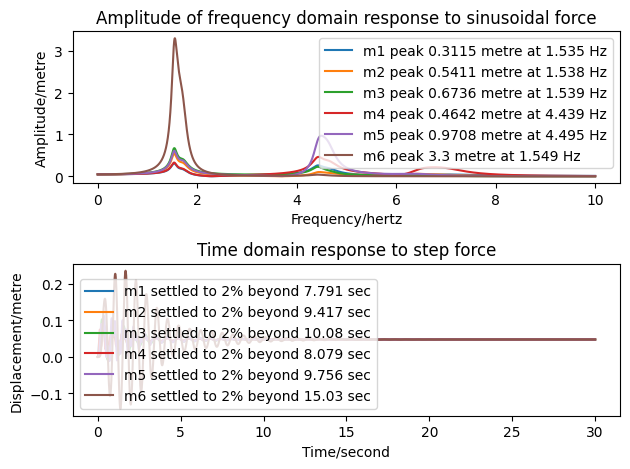

In [151]:
M, L, K, F = MLKF_3_storey_all_floors_damped(3.94, 2.48, 2101, 100, 
                                             3.94, 2.48, 2101, 0, 
                                             3.94, 2.48, 2101, 0,
                                             0.15, 1.143, 261.38, 0, # Mode 3
                                             0.15, 0.423, 124.3, 0, # Mode 2
                                             0.15, 0.288, 15.848, 0 # Mode 1
)

hz = np.linspace(0, 10, 10001)
sec = np.linspace(0, 30, 10001)

fig = plt.figure()
plot(fig, hz, sec, M, L, K, F, None)
fig.canvas.mpl_connect('resize_event', lambda x: fig.tight_layout(pad=2.5))
plt.show()